**Imports**

**Training is taking too much time so I have submitted the colab file without training**

In [96]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.legacy import data
SEED = 2021
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

**Loading the Dataset**

In [98]:
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DLFA/IMDB Dataset.csv")

In [99]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


**Data Visualization**

In [100]:
dataset.isnull().sum() # checking for missing data

review       0
sentiment    0
dtype: int64

In [101]:
dataset.groupby("sentiment").sentiment.count() # checking number of positive and negative samples

sentiment
negative    25000
positive    25000
Name: sentiment, dtype: int64

**Data Preprocessing**

In [102]:
def remove_URL(text):  #removing URL
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)


def remove_html(text):    #removing HTML
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)

#all text to lowercase and remove unwanted signs 
def remove_unwanted_chars(text):
    allowed_chars = """ 0123456789abcdefghijklmnopqrstuvwxyz;,!"".?"""
    clean_text = text.lower()
    for c in clean_text:
        if allowed_chars.find(c) == -1:
            clean_text = clean_text.replace(c, "")
        else:
            pass
    return clean_text

#getting correct words
def make_sentences_correct(text):
    val = re.split('[!.,?;\s]+', text)
    text = " ".join(val)
    return text             


#removing whitespaces from start and end
def remove_white_spaces(text):
    text = text.strip() 
    return text      

In [103]:
dataset["review"] = dataset.review.map(lambda x: remove_URL(x))
dataset["review"] = dataset.review.map(lambda x: remove_html(x))
dataset["review"] = dataset.review.map(lambda x: remove_emoji(x))
dataset["review"] = dataset.review.map(lambda x: remove_unwanted_chars(x))
dataset["review"] = dataset.review.map(lambda x: make_sentences_correct(x))
dataset["review"] = dataset.review.map(lambda x: remove_white_spaces(x))
dataset.reset_index(drop=True, inplace=True)
dataset.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,"petter matteis ""love in the time of money"" is ...",positive


In [104]:
dataset.shape

(50000, 2)

(array([3.5450e+04, 1.0644e+04, 2.7400e+03, 1.0150e+03, 1.3100e+02,
        9.0000e+00, 5.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([   6. ,  250.5,  495. ,  739.5,  984. , 1228.5, 1473. , 1717.5,
        1962. , 2206.5, 2451. ]),
 <a list of 10 Patch objects>)

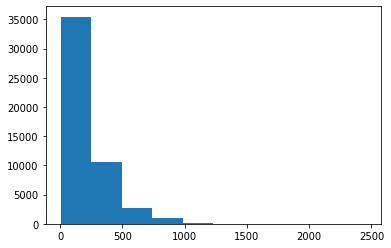

In [105]:
length = []
for item in list(dataset["review"]):
  length.append(len(item.split(" ")))
plt.hist(length)

In [106]:
print("Mean length:", np.mean(length))
print("Minimum length:", np.min(length))
print("Maximum length:", np.max(length))

Mean length: 228.75948
Minimum length: 6
Maximum length: 2451


**Tokenization and Padding**

In [107]:
MAX_LEN = 300
TEXT = data.Field(tokenize='spacy', tokenizer_language = 'en_core_web_sm', fix_length=MAX_LEN, include_lengths = True)
LABEL = data.LabelField(dtype=torch.float)
dataset.to_csv('dataset.csv',index=False)
fields = [('text',TEXT),('label',LABEL)]

In [108]:
dataset = data.TabularDataset.splits(path='', train = 'dataset.csv', format = 'csv', fields = fields, skip_header = True)
dataset = dataset[0]

**Splitting the Dataset**

In [109]:
import random
import io
train, test = dataset.split(split_ratio=0.75, random_state=random.seed(5))

In [110]:
print(len(train), len(test))

37500 12500


In [111]:
TEXT.build_vocab(train, max_size=25000, vectors = "glove.6B.100d", unk_init=torch.Tensor.normal_)
LABEL.build_vocab(train)
LABEL.vocab.stoi['positive'] = 1
LABEL.vocab.stoi['negative'] = 0

**Batching and Loading**

In [112]:
BATCH_SIZE = 50
device = 'cpu'  # device configuration

In [113]:
train_iterator, _, test_iterator = data.BucketIterator.splits((train, _, test), batch_size = BATCH_SIZE, sort_key=lambda x:len(x.text), 
                                                            sort_within_batch=True, device = device)

**Building the LSTM Model**

In [114]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

In [115]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded.to(device), text_lengths.to(device))
        packed_output, (hidden, cell) = self.rnn(packed_embedded.to(device))
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output.to(device))
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)) 
        return self.fc(hidden)

model = LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)

In [116]:
model

LSTM(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn): LSTM(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [117]:
optimizer = optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

**Training the Model**

In [118]:
def train(model, iterator, optimizer, criterion):
    loss = acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        text, text_lengths = batch.text
        predictions = model(text, text_lengths.to(device)).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        acc += acc.item()
        
    return loss / len(iterator), acc / len(iterator)

In [ ]:
EPOCHS = 5
loss_lis = []
acc_lis = []
for epoch in range(EPOCHS):
  train_loss, train_acc = train(model.to(device), train_iterator, optimizer, criterion.to(device))
  loss_lis.append(train_loss)
  acc_lis.append(train_acc)
  print("Epoch:", epoch, "Training loss:", train_loss, "Training accuracy:", 100*train_acc)

**Accuracy Plot**

In [ ]:
plt.plot(acc_lis)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy plot")

**Loss Plot**

In [ ]:
plt.plot(loss_lis)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss plot")